# Tutorial: `dynamiqs`

In this tutorial, you will learn how to use the software package `dynamiqs`.
Much more tutorials and documentation can be found on the `dynamiqs` [website](https://www.dynamiqs.org).

## What is `dynamiqs`?

`dynamiqs` allows the high-performance simulation of quantum systems with `JAX`, a GPU-oriented library developed by Google.

In contrast to other existing simulation packages, `dynamiqs` offers the following advantages:
- **Differentiable:** 
  
  The quantum solvers are fully differentiable. This is extremely helpful when dealing with optimal control, parameter estimation, experiment fitting, etc.
- **GPU Accelerated:**
  
  Thanks to `JAX`, `dynamiqs` allows to transition seamlessly between CPU, GPU and TPU simulations, and run batches of simulations at once. This is very powerful when sweeping parameters.
- **Built on `JAX`:**
  
    `dynamiqs` benefits from the JAX ecosystem, that is built for both high-performance numerical computing and machine learning. This makes it also easy to extend the functionalities of `dynamiqs`.

We begin with some basic imports and some plotting functions that we will later use.

In [25]:
import dynamiqs as dq
import jax
import jax.numpy as jnp # the JAX version of numpy
from matplotlib import pyplot as plt

**Setting a computing device:** If we have multiple computing devices availablem, such as CPU, GPU, or TPU, we can choose which one should be used by `dynamiqs`.
We can see the availability of devices by calling:

In [26]:
jax.devices()

[CpuDevice(id=0)]

If multiple devices are available, we can set the device used for `dynamiqs` calculations using `dq.set_device(device, index)` where `device` is one of `cpu`, `gpu` or `tpu`, and `index` is an integer (in case of multiple GPU devices, for example, defaults to 0).

Here, we will use a regular cpu:

In [27]:
dq.set_device('cpu')

**Precision:** We can set the default floating point precision used in `dynamiqs`. There are two options available:
- 'simple' sets default precision to float32 and complex64 (default setting),
- 'double' sets default precision to float64 and complex128.
It is important to know that for most GPUs the `simple` precision is the native precision and a higher precision will slow down computations considerably.

Here, we use the default setting:

In [28]:
dq.set_precision('simple')

---

## 1. Simulating a harmonic oscillator

In this first section, we begin with a simple simulation of a quantum harmonic oscillator. We initialize the system in a coherent state $\ket{\alpha}$, and then evolve it in time with Hamiltonian $H = \omega \hat{a}^\dagger \hat{a}$. This will show a simple rotation in phase space of the coherent state.

Let us initialize the system, the operators and the scope of the simulation.

In [29]:
# parameters
n = 32  # number of Fock states
omega = 1.0  # detuning
T = jnp.pi / omega  # time of evolution

# operators
a = dq.destroy(n)  # annihilation operator
H = -omega * dq.dag(a) @ a  # Hamiltonian

# initial state and save time
psi0 = dq.coherent(n, 2.0)  # coherent state
t_save = jnp.linspace(0, T, 50)  # save times

Notice that we use the `@` for matrix-matrix multiplication of two Jax arrays (`dq.dag(a)` and `a`) here. (The `*` operator is an element-wise operator by default)

Then, we can run `dq.sesolve` which will solve the Schödinger equation. 

In [30]:
# solve Schrodinger equation
result = dq.sesolve(H, psi0, t_save)
print(result)

|██████████| 100.0% ◆ elapsed 4.11ms ◆ remaining 0.00ms

==== SESolveResult ====
Solver : Tsit5
Infos  : 59 steps (59 accepted, 0 rejected)
States : QArray complex64 (50, 32, 1) | 12.5 Kb


In a few tens of milliseconds, we get our full time evolution, with the evolved state at each time step. Let us plot these states in phase space for multiple times.

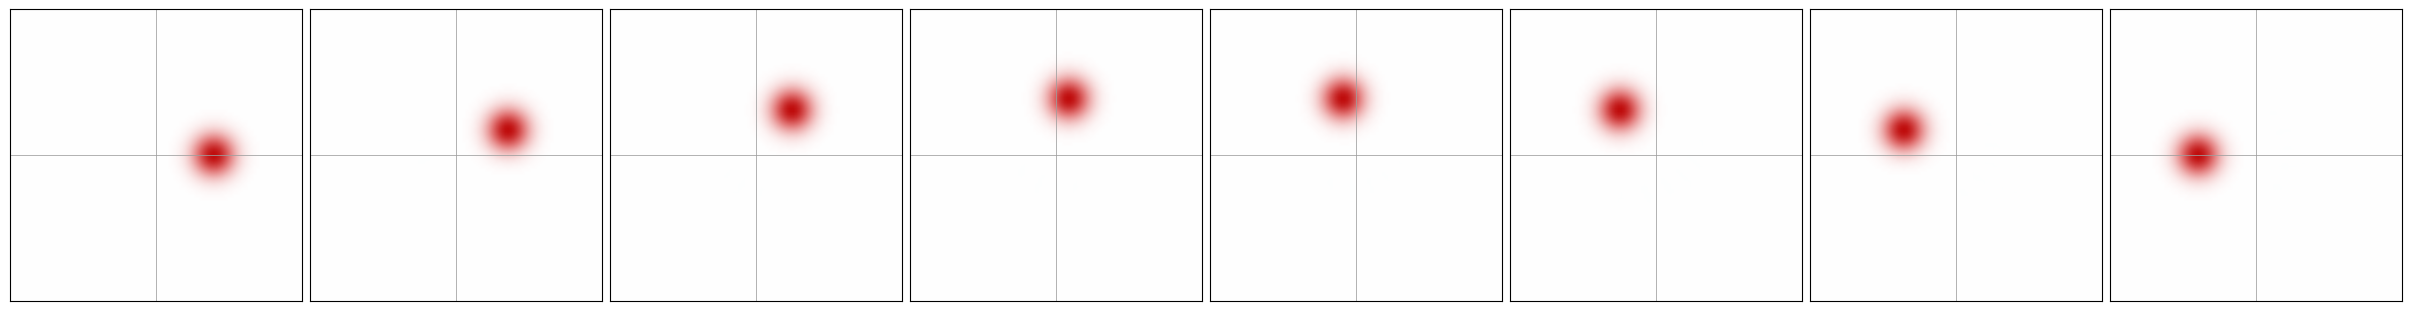

In [31]:
dq.plot.wigner_mosaic(result.states, cross = True)

We can also generate a GIF to visualize the evolution of the state.

100%|██████████| 50/50 [00:02<00:00, 22.83it/s]


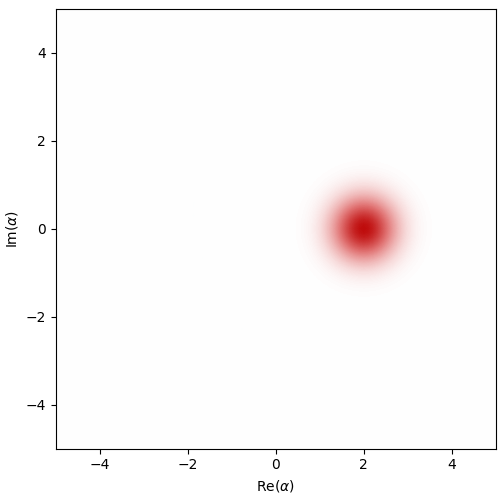

In [32]:
dq.plot.wigner_gif(result.states, gif_duration = 2, fps = 25)

As expected, the coherent state rotates in phase space. We get a simple harmonic oscillator with frequency $\omega$. After some time $T = \pi / \omega$, the state has performed rotated by an angle $\pi$ in phase space.

## 2. The oscillator is losing photons!

Let us now assume that our oscillator is losing photons. We can model this by adding a dissipation term $\kappa \mathcal{D}[a]$ the the problem. The corresponding equation to solve is now the Lindblad master equation, a generalization of the Schrödinger equation for open quantum systems. Photons will thus be lost at rate $\kappa$ to the environment.

In dynamiqs, with simply need to define this jump operator, and we can then integrate the master equation as before using `dq.mesolve`.

In [33]:
# define the jump operator
kappa = 0.5
jump_ops = [jnp.sqrt(kappa) * a]

# solve the Lindblad master equation with dynamiqs.mesolve
result = dq.mesolve(H, jump_ops, psi0, t_save)

|██████▊   |  67.5% ◆ elapsed 4.05ms ◆ remaining 0.00ms

Again, let us plot the states in phase space for multiple times.

|██████▊   |  67.5% ◆ elapsed 7.06ms ◆ remaining 0.00ms

|██████████| 100.0% ◆ elapsed 75.61ms ◆ remaining 0.00ms


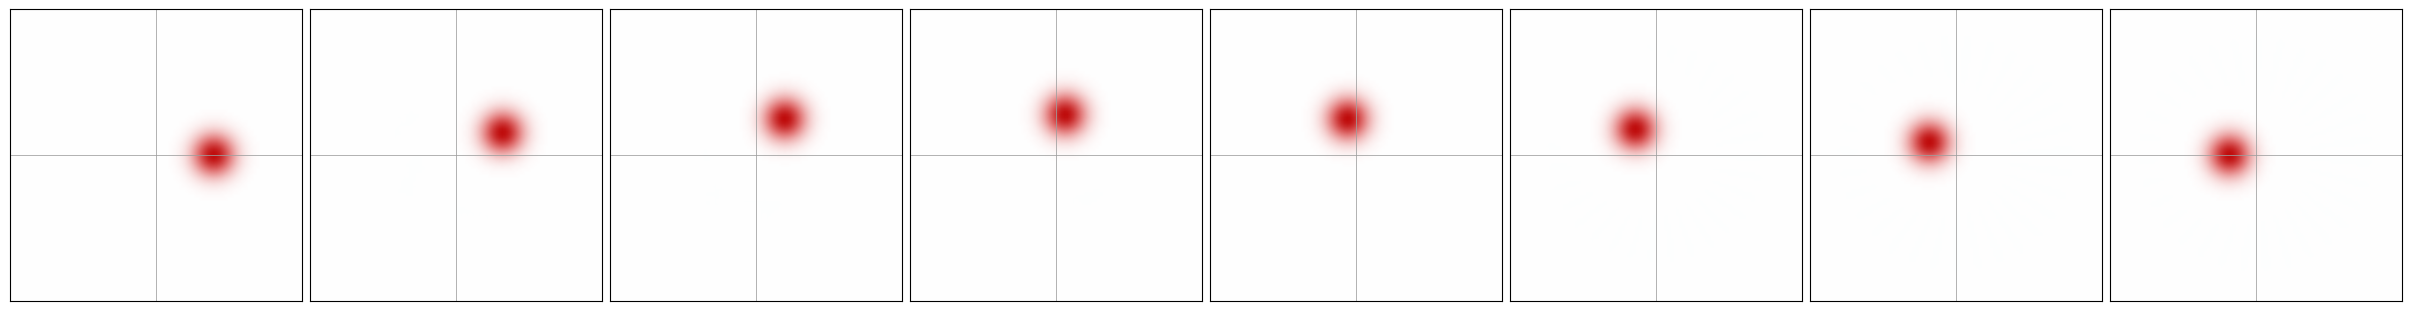

|          |   0.3% ◆ elapsed 7.07ms ◆ remaining 0.00ms

|██████████| 100.0% ◆ elapsed 9.77ms ◆ remaining 0.00ms


In [ ]:
dq.plot.wigner_mosaic(result.states, cross = True)

Compared to our previous simulation, the state now spirals towards the center of phase space and has a reduced amplitude at the final time. We will check this by computing the total number of photons in the oscillator against time. To do so, we will provide an additional argument to `dynamiqs.mesolve`, which is the observable we want to measure.

|██████████| 100.0% ◆ elapsed 9.07ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 5.66ms ◆ remaining 0.00ms


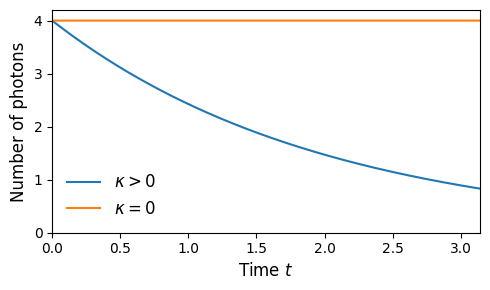

In [ ]:
# observable to measure (number of photons)
exp_ops = [dq.dag(a) @ a]

# run dynamiqs.mesolve with a finer time grid
t_save = jnp.linspace(0, T, 200)
result_loss = dq.mesolve(H, jump_ops, psi0, t_save, exp_ops=exp_ops)

# also run dynamiqs.sesolve without dissipation for comparison
result_noloss = dq.sesolve(H, psi0, t_save, exp_ops=exp_ops)

# plot the observable against time
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t_save, result_loss.expects[0].real, label=r"$\kappa > 0$")
ax.plot(t_save, result_noloss.expects[0].real, label=r"$\kappa = 0$")
ax.set_ylim((0, 4.2))
ax.set_xlim((0, T))
ax.set_xlabel(r"Time $t$", fontsize=12)
ax.set_ylabel(r"Number of photons", fontsize=12)
ax.legend(fontsize=12, frameon=False)
plt.tight_layout()
plt.show()

### Gradients!
One cool thing about `dynamiqs` is the ability to compute gradients. Suppose that in the above example, we want to compute the gradient of the number of photons in the final state at time $T, \overline{n} = \mathrm{Tr}[\hat{a}^\dagger \hat{a} \hat{\rho(T)}]$, with respect to the frequency $\omega$, the decay rate $\kappa$ and the initial coherent state amplitude $\alpha_0$.

In [ ]:
# parameters
alpha0 = 1.0    # initial coherent state amplitude
T = 2 * jnp.pi  # total evolution time (one full revolution)

def population(omega, kappa, alpha0):
    """Return the oscillator population after time evolution."""
    # initialize operators, initial state and saving times
    a = dq.destroy(n)
    H = omega * dq.dag(a) @ a
    jump_ops = [jnp.sqrt(kappa) * a]
    psi0 = dq.coherent(n, alpha0)
    tsave = jnp.linspace(0, T, 101)

    # run simulation
    result = dq.mesolve(H, jump_ops, psi0, tsave)

    return dq.expect(dq.number(n), result.states[-1]).real

# compute gradient with respect to omega, kappa and alpha
grad_population = jax.grad(population, argnums=(0, 1, 2))
grads = grad_population(omega, kappa, alpha0)
print(f'Gradient w.r.t. delta : {grads[0]:.4f}')
print(f'Gradient w.r.t. kappa : {grads[1]:.4f}')
print(f'Gradient w.r.t. alpha0: {grads[2]:.4f}')

|██████████| 100.0% ◆ elapsed 18.57ms ◆ remaining 0.00ms


Gradient w.r.t. delta : 0.0000
Gradient w.r.t. kappa : -0.2715
Gradient w.r.t. alpha0: 0.0864


### Batching!

One cool thing about the fact that `dynamiqs` is using `JAX` is that it allows to run many independent simulations concurrently, also called **batching**.
This can dramatically speedup simulations, especially on GPUs. Importantly, this does not use any for-loops under the hood and is therefore much more efficient.

For example, we can sweep over the paramters $\omega$, $\kappa$ and $\alpha_0$:

In [13]:
omega = jnp.linspace(0.5, 1.5, 10)
kappa = jnp.linspace(0.1, 1.0, 8)
alpha0 = jnp.linspace(0.5, 1.5, 5)

H = omega[:, None, None] * dq.dag(a) @ a
jump_ops = [jnp.sqrt(kappa)[:, None, None] * a]
psi0 = dq.coherent(n, alpha0)

T = 2 * jnp.pi
tsave = jnp.linspace(0, T, 101)

result = dq.mesolve(H, jump_ops, psi0, tsave)
print(result.states.shape)

(10, 8, 5, 101, 32, 32)


|██████████| 100.0% ◆ elapsed 3.28s ◆ remaining 0.00ms  


We see that the resulting time-evolved density matrix has now more dimensions, associated with the sweeps of the different parameters.